# CNNs en CIFAR10

In [1]:
# required imports
import keras
from keras.callbacks    import LearningRateScheduler
from keras.layers       import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D
from keras.models       import Sequential
from keras.optimizers   import SGD, rmsprop


import _pickle as pickle
import math
import matplotlib.pyplot as plt
import numpy as np
import os

Using TensorFlow backend.


# Importación del dataset

In [2]:
def load_CIFAR_one(file_path):
    with open(file_path, 'rb') as f:
        data_dict = pickle.load(f, encoding='latin1')
    X = data_dict['data']
    Y = data_dict['labels']
    Y = np.array(Y)
    return X, Y

def load_CIFAR10(PATH):
    xs = []
    ys = []
    for b in range(1, 6):
        f = os.path.join(PATH, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_one(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_one(os.path.join(PATH, 'test_batch'))
    
    #Creación de matrices de validación
    #Se fusionan los conjuntos Xtr e Ytr
    training_data = Xtr
    training_data_y = Ytr.reshape((50000, 1))
    training_data = np.append(training_data, training_data_y, axis=1)

    #Luego, se extrae el conjunto de validación a partir del conjunto de entrenamiento
    Xtr = training_data[:45000, :3072]
    Ytr = training_data[:45000, 3072]
    Xv = training_data[45000:, :3072]
    Yv = training_data[45000:, 3072]
    
    return Xtr, Ytr, Xte, Yte, Xv, Yv


x_train,y_train, x_test,y_test, x_val,y_val = load_CIFAR10('./data')
label_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

In [3]:
x_train=x_train/255.0
x_test=x_test/255.0
x_val=x_val/255.0

In [4]:
print(x_train.shape)
print(x_train[0].shape)
print(x_train[-1].shape)

(45000, 3072)
(3072,)
(3072,)


In [5]:
def plot_hist(hist, axis1 = None, axis2 = None):
    plt.figure(1,figsize=(12,5))

    plt.subplot(121)
    plt.plot(hist.history['loss'],     'go--', label = 'Training')
    plt.plot(hist.history['val_loss'], 'bo--', label = 'Validation')
    plt.legend(loc="upper right", fancybox= True)
    plt.xlabel(u'Numero de iteración')
    plt.ylabel('loss')
    if (axis1): 
        plt.axis(axis1)
    plt.grid(True)

    plt.subplot(122)
    plt.plot(hist.history['acc'],     'go--', label = 'Training')
    plt.plot(hist.history['val_acc'], 'bo--', label = 'Validation')
    plt.legend(loc="lower right", fancybox= True)
    plt.xlabel(u'Numero de iteración')
    plt.ylabel('acc')
    if (axis2):
        plt.axis(axis2)
    plt.grid(True)

    plt.show()

In [6]:
def model_eval(model, xt, yt):
    result = model.evaluate(xt, yt)
    print('\nloss: ' + str(result[0]) + ' - acc: ' + str(result[1]))

# Trasformación del dataset 

In [7]:
num_classes = len(label_names)

x_train = x_train.reshape((x_train.shape[0],32,32,3))
#x_train = x_train.transpose([0, 2, 3, 1]) #only if 'tf' dim-ordering is to be used
x_test= x_test.reshape((x_test.shape[0],32,32,3))
#x_test= x_test.transpose([0, 2, 3, 1])#remove if 'th' dim-ordering is to be used
x_val= x_val.reshape((x_val.shape[0],32,32,3))
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)

# Modelo CPCPFF

In [8]:
model = Sequential()
model.add(Convolution2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu')) 
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
activation_2 (Activation)    (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
__________

# Entregamiento con SGD

In [9]:
def step_decay(epoch):
    initial_lrate = 0.001
    lrate = initial_lrate * math.pow(0.5, math.floor((1+epoch)/5))
    lrate = max(lrate,0.00001)
    return lrate

opt = SGD(lr=0.0, momentum=0.9, decay=0.0)
lrate = LearningRateScheduler(step_decay)

In [10]:
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
hist = model.fit(x_train, y_train, batch_size=500, epochs=25,
          validation_data=(x_test, y_test), shuffle=True, callbacks=[lrate], verbose=1)
model.save('model/model-1c')

Train on 45000 samples, validate on 10000 samples
Epoch 1/25
45000/45000 [==============================] - 123s - loss: 2.2767 - acc: 0.1653 - val_loss: 2.2491 - val_acc: 0.2328

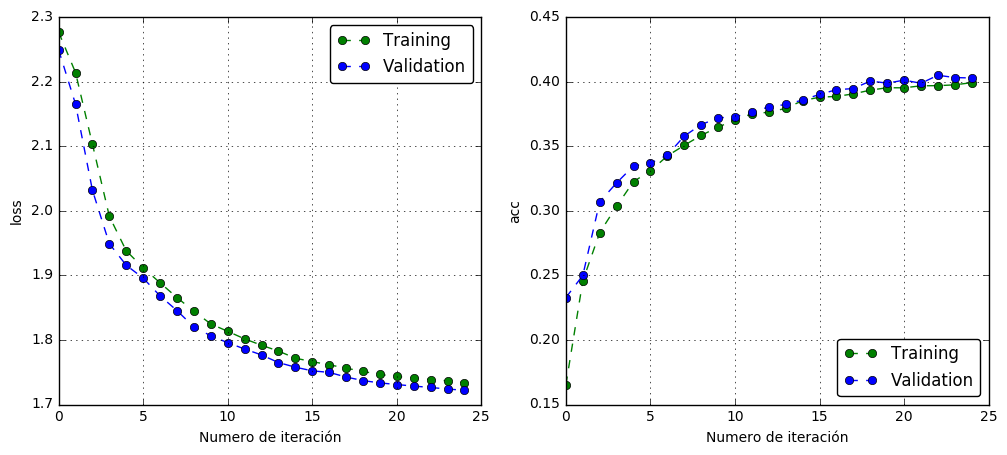

In [11]:
plot_hist(hist)

In [12]:
model_eval(model, x_test, y_test)

 9952/10000 [============================>.] - ETA: 0s 

# Entrenamiento con RMSProp

In [24]:
opt = rmsprop(lr=0.001, decay=1e-6)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
hist_rms = model.fit(x_train, y_train, batch_size=500, epochs=25,
          validation_data=(x_test, y_test), shuffle=True, verbose=1)
model.save('model/model-1d')

Train on 45000 samples, validate on 10000 samples
Epoch 1/25
45000/45000 [==============================] - 125s - loss: 1.6652 - acc: 0.4276 - val_loss: 1.5937 - val_acc: 0.4319

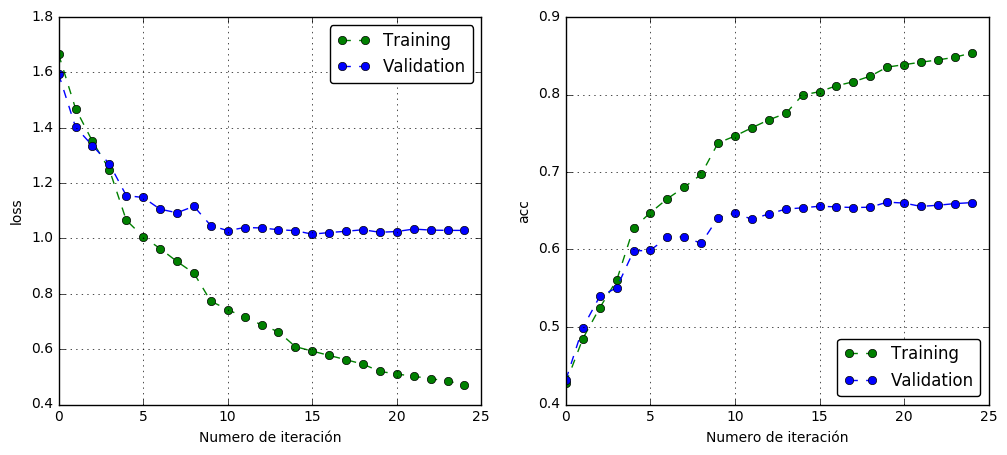

In [33]:
plot_hist(hist_rms)

In [26]:
model_eval(model, x_test, y_test)

 9984/10000 [============================>.] - ETA: 0s 

# E

In [27]:
model = Sequential()

# Frist CxCxP
model.add(Convolution2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Convolution2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Second CxCxP
model.add(Convolution2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Convolution2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Feed Forward
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_5 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
activation_6 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 128)       73856     
__________

In [30]:
opt = rmsprop(lr=0.001, decay=1e-6)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
hist_e1 = model.fit(x_train, y_train, batch_size=400, epochs=25,
          validation_data=(x_test, y_test), shuffle=True, verbose=1)
model.save('model/model-1e')

Train on 45000 samples, validate on 10000 samples
Epoch 1/25
45000/45000 [==============================] - 660s - loss: 1.8371 - acc: 0.3480 - val_loss: 1.7439 - val_acc: 0.3790

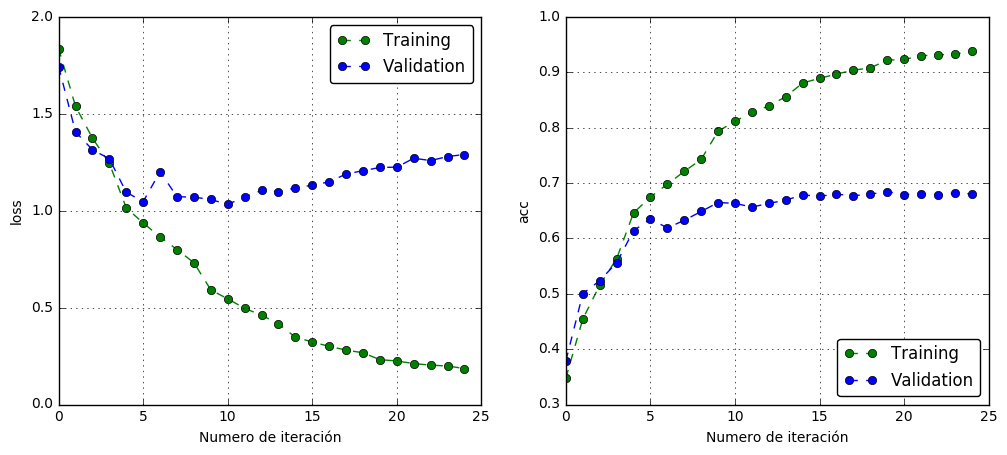

In [32]:
plot_hist(hist_e1)

In [34]:
model_eval(model, x_test, y_test)

10000/10000 [==============================] - 42s     

## mas menos

In [13]:
model = Sequential()

# Frist CxCxP
model.add(Convolution2D(128, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Convolution2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Second CxCxP
model.add(Convolution2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Convolution2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Feed Forward
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 128)       3584      
_________________________________________________________________
activation_5 (Activation)    (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 128)       147584    
_________________________________________________________________
activation_6 (Activation)    (None, 32, 32, 128)       0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 64)        73792     
__________

In [ ]:
opt = rmsprop(lr=0.001, decay=1e-6)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
hist = model.fit(x_train, y_train, batch_size=250, epochs=25,
          validation_data=(x_test, y_test), shuffle=True, verbose=1)
model.save('model/model-1e2')

Train on 45000 samples, validate on 10000 samples
Epoch 1/25
45000/45000 [==============================] - 1116s - loss: 1.9450 - acc: 0.3002 - val_loss: 1.6102 - val_acc: 0.4254

In [ ]:
plot_hist(hist)

In [ ]:
model_eval(model, x_test, y_test)

## Cambio size filtro

In [ ]:
model = Sequential()

# Frist CxCxP
model.add(Convolution2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Convolution2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Second CxCxP
model.add(Convolution2D(64, (6, 6), padding='same'))
model.add(Activation('relu'))
model.add(Convolution2D(64, (6, 6), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Feed Forward
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary()

In [ ]:
opt = rmsprop(lr=0.001, decay=1e-6)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
hist = model.fit(x_train, y_train, batch_size=250, epochs=25,
          validation_data=(x_test, y_test), shuffle=True, verbose=1)
model.save('model/model-1e3')

In [ ]:
plot_hist(hist)

In [ ]:
model_eval(model, x_test, y_test)

# F

In [44]:
model = Sequential()

# Frist CxCxP
model.add(Convolution2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Convolution2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Convolution2D(64, (3, 3), strides=(2, 2), padding='valid'))
model.add(Dropout(0.25))

# Second CxCxP
model.add(Convolution2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Convolution2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Convolution2D(64, (3, 3), strides=(2, 2), padding='valid'))
model.add(Dropout(0.25))

# Feed Forward
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_17 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
activation_18 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 15, 15, 64)        36928     
_________________________________________________________________
dropout_5 (Dropout)          (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 15, 15, 128)       73856     
__________

In [ ]:
opt = rmsprop(lr=0.001, decay=1e-6)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
hist = model.fit(x_train, y_train, batch_size=50, epochs=25,
          validation_data=(x_test, y_test), shuffle=True, callbacks=[lrate], verbose=1)
model.save('model/model-1f')

In [ ]:
plot_hist(hist)

In [ ]:
model_eval(model, x_test, y_test)

# G

In [46]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    featurewise_center=False,            # set input mean to 0 over the dataset
    samplewise_center=False,             # set each sample mean to 0
    featurewise_std_normalization=False, # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,                 # apply ZCA whitening
    rotation_range=0,                    # randomly rotate images (degrees, 0 to 180)
    width_shift_range=0.1,               # randomly shift images horizontally (fraction of width)
    height_shift_range=0.1,              # randomly shift images vertically (fraction of height)
    horizontal_flip=True,                # randomly flip images
    vertical_flip=False)                 # randomly flip images
datagen.fit(x_train)

In [ ]:
hist = model.fit_generator(
    datagen.flow(x_train, y_train,batch_size=batch_size),
    steps_per_epoch=x_train.shape[0]// batch_size,
    epochs=25, validation_data=(x_val, y_val))
model.save('model/model-1g')

In [ ]:
plot_hist(hist)

In [ ]:
model_eval(model, x_test, y_test)